# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_power"],
    "x_transforms_target": ["unit_power"],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_power']
x_transforms_target ['unit_power']
Average magnitude, source: 0.8961075
Average power, source: 1.0


Average magnitude, target: 0.91523236
Average power, target: 1.0


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 1990.7888, train_label_loss: 4.6593, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3929.2051, train_label_loss: 4.1821, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4017.2617, train_label_loss: 3.4630, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4025.2069, train_label_loss: 2.6789, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4012.1242, train_label_loss: 2.4808, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3962.9875, train_label_loss: 2.0817, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4069.0766, train_label_loss: 1.7950, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4068.8534, train_label_loss: 1.5956, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4093.4244, train_label_loss: 1.5899, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4154.0497, train_label_loss: 1.5999, 


epoch: 1, source_val_acc_label: 0.7763, target_val_acc_label: 0.7312, source_val_label_loss: 1.4164, target_val_label_loss: 1.6287, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 496.4320, train_label_loss: 1.3508, 


epoch: 2, [batch: 5 / 45], examples_per_second: 3973.9210, train_label_loss: 1.1871, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4074.2895, train_label_loss: 1.0874, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4084.2981, train_label_loss: 1.1225, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4076.7478, train_label_loss: 0.9031, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4028.3246, train_label_loss: 0.9965, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4121.6146, train_label_loss: 1.0056, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4121.0741, train_label_loss: 0.8856, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4165.9919, train_label_loss: 1.0708, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4232.0014, train_label_loss: 0.9353, 


epoch: 2, source_val_acc_label: 0.8173, target_val_acc_label: 0.7735, source_val_label_loss: 0.9680, target_val_label_loss: 1.2200, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 491.0309, train_label_loss: 0.9640, 


epoch: 3, [batch: 5 / 45], examples_per_second: 3973.5142, train_label_loss: 0.9509, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4076.9185, train_label_loss: 0.8133, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4070.2418, train_label_loss: 0.9190, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4088.6072, train_label_loss: 0.8257, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4027.4475, train_label_loss: 1.0103, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4124.6591, train_label_loss: 0.7179, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4132.0139, train_label_loss: 0.7100, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4167.6210, train_label_loss: 0.5365, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4225.4030, train_label_loss: 0.6258, 


epoch: 3, source_val_acc_label: 0.8692, target_val_acc_label: 0.7987, source_val_label_loss: 0.7242, target_val_label_loss: 1.0717, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 487.1903, train_label_loss: 0.8118, 


epoch: 4, [batch: 5 / 45], examples_per_second: 3984.3153, train_label_loss: 0.8091, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4078.9726, train_label_loss: 0.6356, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4083.1261, train_label_loss: 0.7457, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4102.5335, train_label_loss: 0.7312, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4032.8259, train_label_loss: 0.5173, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4137.3471, train_label_loss: 0.5706, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4139.1891, train_label_loss: 0.6480, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4176.7962, train_label_loss: 0.5033, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4234.0372, train_label_loss: 0.6848, 


epoch: 4, source_val_acc_label: 0.8994, target_val_acc_label: 0.8184, source_val_label_loss: 0.5676, target_val_label_loss: 0.9628, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 484.6070, train_label_loss: 0.4682, 


epoch: 5, [batch: 5 / 45], examples_per_second: 3981.1313, train_label_loss: 0.3400, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4080.1691, train_label_loss: 0.4585, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4091.4107, train_label_loss: 0.3576, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4090.5611, train_label_loss: 0.4732, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4028.6401, train_label_loss: 0.3322, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4132.7514, train_label_loss: 0.3872, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4140.7922, train_label_loss: 0.3715, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4167.9281, train_label_loss: 0.3360, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4227.6963, train_label_loss: 0.3830, 


epoch: 5, source_val_acc_label: 0.9154, target_val_acc_label: 0.8308, source_val_label_loss: 0.4705, target_val_label_loss: 0.8794, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 491.9167, train_label_loss: 0.2367, 


epoch: 6, [batch: 5 / 45], examples_per_second: 3978.9292, train_label_loss: 0.2794, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4078.1062, train_label_loss: 0.4079, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4085.0999, train_label_loss: 0.4098, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4075.5914, train_label_loss: 0.3324, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4017.3751, train_label_loss: 0.3455, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4138.5749, train_label_loss: 0.3477, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4125.9887, train_label_loss: 0.3085, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4171.8313, train_label_loss: 0.3344, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4223.7010, train_label_loss: 0.3332, 


epoch: 6, source_val_acc_label: 0.9346, target_val_acc_label: 0.8457, source_val_label_loss: 0.4033, target_val_label_loss: 0.8524, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 487.6535, train_label_loss: 0.5058, 


epoch: 7, [batch: 5 / 45], examples_per_second: 3967.2506, train_label_loss: 0.2174, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4068.3328, train_label_loss: 0.2417, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4082.3985, train_label_loss: 0.2762, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4039.7419, train_label_loss: 0.2802, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4013.3134, train_label_loss: 0.2020, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4115.7362, train_label_loss: 0.2380, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4133.4783, train_label_loss: 0.2579, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4165.5489, train_label_loss: 0.2759, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4216.8968, train_label_loss: 0.2157, 


epoch: 7, source_val_acc_label: 0.9404, target_val_acc_label: 0.8547, source_val_label_loss: 0.3764, target_val_label_loss: 0.8251, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 489.0099, train_label_loss: 0.2569, 


epoch: 8, [batch: 5 / 45], examples_per_second: 3979.3255, train_label_loss: 0.1728, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4081.0944, train_label_loss: 0.0915, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4082.7177, train_label_loss: 0.2419, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4071.5332, train_label_loss: 0.1163, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4014.0934, train_label_loss: 0.1950, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4129.3884, train_label_loss: 0.1910, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4121.5024, train_label_loss: 0.1553, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4158.7258, train_label_loss: 0.2654, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4216.5120, train_label_loss: 0.1495, 


epoch: 8, source_val_acc_label: 0.9436, target_val_acc_label: 0.8551, source_val_label_loss: 0.3585, target_val_label_loss: 0.7896, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 486.8014, train_label_loss: 0.0960, 


epoch: 9, [batch: 5 / 45], examples_per_second: 3985.8079, train_label_loss: 0.2054, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4081.6642, train_label_loss: 0.1183, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4071.1219, train_label_loss: 0.0839, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4076.9734, train_label_loss: 0.1065, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4026.8217, train_label_loss: 0.1547, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4132.4288, train_label_loss: 0.3401, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4135.6070, train_label_loss: 0.1671, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4165.2587, train_label_loss: 0.1907, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4222.3485, train_label_loss: 0.1311, 


epoch: 9, source_val_acc_label: 0.9462, target_val_acc_label: 0.8564, source_val_label_loss: 0.3604, target_val_label_loss: 0.7707, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 491.9584, train_label_loss: 0.2409, 


epoch: 10, [batch: 5 / 45], examples_per_second: 3972.4387, train_label_loss: 0.1628, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4073.5164, train_label_loss: 0.2329, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4075.2259, train_label_loss: 0.1427, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4067.0264, train_label_loss: 0.1796, 


epoch: 10, [batch: 23 / 45], examples_per_second: 3999.9589, train_label_loss: 0.2833, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4125.0523, train_label_loss: 0.1270, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4107.8975, train_label_loss: 0.2810, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4155.4676, train_label_loss: 0.0778, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4207.7932, train_label_loss: 0.2344, 


epoch: 10, source_val_acc_label: 0.9455, target_val_acc_label: 0.8571, source_val_label_loss: 0.3513, target_val_label_loss: 0.7531, 


New best


epoch: 11, [batch: 1 / 45], examples_per_second: 490.5556, train_label_loss: 0.2172, 


epoch: 11, [batch: 5 / 45], examples_per_second: 3977.3140, train_label_loss: 0.1065, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4069.3013, train_label_loss: 0.2343, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4064.2081, train_label_loss: 0.1675, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4073.5864, train_label_loss: 0.3125, 


epoch: 11, [batch: 23 / 45], examples_per_second: 3998.1921, train_label_loss: 0.1170, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4115.2780, train_label_loss: 0.1350, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4116.1665, train_label_loss: 0.1308, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4156.0074, train_label_loss: 0.0766, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4209.2793, train_label_loss: 0.2605, 


epoch: 11, source_val_acc_label: 0.9519, target_val_acc_label: 0.8637, source_val_label_loss: 0.3463, target_val_label_loss: 0.7404, 


New best


epoch: 12, [batch: 1 / 45], examples_per_second: 491.0355, train_label_loss: 0.1558, 


epoch: 12, [batch: 5 / 45], examples_per_second: 3972.9206, train_label_loss: 0.1216, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4061.0470, train_label_loss: 0.3083, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4065.1050, train_label_loss: 0.2297, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4062.5765, train_label_loss: 0.1070, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4015.6697, train_label_loss: 0.2348, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4117.5559, train_label_loss: 0.1587, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4100.7732, train_label_loss: 0.0861, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4150.3284, train_label_loss: 0.2240, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4222.1850, train_label_loss: 0.1723, 


epoch: 12, source_val_acc_label: 0.9519, target_val_acc_label: 0.8673, source_val_label_loss: 0.3228, target_val_label_loss: 0.7289, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 487.0111, train_label_loss: 0.0862, 


epoch: 13, [batch: 5 / 45], examples_per_second: 3974.7568, train_label_loss: 0.1282, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4080.9371, train_label_loss: 0.1362, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4076.1142, train_label_loss: 0.1715, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4072.7922, train_label_loss: 0.1123, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4020.1736, train_label_loss: 0.1141, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4128.6364, train_label_loss: 0.2879, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4130.6350, train_label_loss: 0.0896, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4156.0226, train_label_loss: 0.0875, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4209.9732, train_label_loss: 0.1974, 


epoch: 13, source_val_acc_label: 0.9532, target_val_acc_label: 0.8688, source_val_label_loss: 0.3255, target_val_label_loss: 0.7283, 


New best


epoch: 14, [batch: 1 / 45], examples_per_second: 488.0113, train_label_loss: 0.0846, 


epoch: 14, [batch: 5 / 45], examples_per_second: 3964.3359, train_label_loss: 0.0921, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4066.6927, train_label_loss: 0.1453, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4064.0530, train_label_loss: 0.0854, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4070.3661, train_label_loss: 0.0730, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4018.9314, train_label_loss: 0.1582, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4122.2783, train_label_loss: 0.1169, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4125.1022, train_label_loss: 0.1936, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4159.8210, train_label_loss: 0.0369, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4214.8237, train_label_loss: 0.1867, 


epoch: 14, source_val_acc_label: 0.9564, target_val_acc_label: 0.8703, source_val_label_loss: 0.3277, target_val_label_loss: 0.7468, 


New best


epoch: 15, [batch: 1 / 45], examples_per_second: 489.6903, train_label_loss: 0.1178, 


epoch: 15, [batch: 5 / 45], examples_per_second: 3965.1720, train_label_loss: 0.1428, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4075.1239, train_label_loss: 0.1216, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4070.1640, train_label_loss: 0.1789, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4084.6378, train_label_loss: 0.0779, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4029.0688, train_label_loss: 0.1210, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4121.3280, train_label_loss: 0.0278, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4133.7493, train_label_loss: 0.1044, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4154.0721, train_label_loss: 0.1235, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4219.5972, train_label_loss: 0.0858, 


epoch: 15, source_val_acc_label: 0.9532, target_val_acc_label: 0.8729, source_val_label_loss: 0.3167, target_val_label_loss: 0.7262, 


New best


epoch: 16, [batch: 1 / 45], examples_per_second: 485.8724, train_label_loss: 0.1566, 


epoch: 16, [batch: 5 / 45], examples_per_second: 3972.5762, train_label_loss: 0.1941, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4073.4495, train_label_loss: 0.1927, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4082.3924, train_label_loss: 0.1482, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4084.5276, train_label_loss: 0.1389, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4027.5486, train_label_loss: 0.1063, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4132.4304, train_label_loss: 0.1751, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4119.6309, train_label_loss: 0.1277, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4160.7809, train_label_loss: 0.0718, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4216.4110, train_label_loss: 0.0427, 


epoch: 16, source_val_acc_label: 0.9609, target_val_acc_label: 0.8754, source_val_label_loss: 0.3089, target_val_label_loss: 0.7134, 


New best


epoch: 17, [batch: 1 / 45], examples_per_second: 488.3086, train_label_loss: 0.1569, 


epoch: 17, [batch: 5 / 45], examples_per_second: 3971.2771, train_label_loss: 0.2073, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4078.1657, train_label_loss: 0.1982, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4081.9915, train_label_loss: 0.0756, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4079.7890, train_label_loss: 0.1907, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4022.4204, train_label_loss: 0.1134, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4130.5897, train_label_loss: 0.0985, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4125.9122, train_label_loss: 0.0791, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4170.0829, train_label_loss: 0.1264, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4217.1056, train_label_loss: 0.1846, 


epoch: 17, source_val_acc_label: 0.9590, target_val_acc_label: 0.8778, source_val_label_loss: 0.3177, target_val_label_loss: 0.7045, 


New best


epoch: 18, [batch: 1 / 45], examples_per_second: 486.5908, train_label_loss: 0.1053, 


epoch: 18, [batch: 5 / 45], examples_per_second: 3964.3936, train_label_loss: 0.1571, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4073.3703, train_label_loss: 0.0607, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4080.0818, train_label_loss: 0.0858, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4081.0501, train_label_loss: 0.1734, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4023.0080, train_label_loss: 0.1407, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4128.3301, train_label_loss: 0.1145, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4114.3340, train_label_loss: 0.1512, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4162.4961, train_label_loss: 0.1132, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4212.0513, train_label_loss: 0.0387, 


epoch: 18, source_val_acc_label: 0.9551, target_val_acc_label: 0.8776, source_val_label_loss: 0.3124, target_val_label_loss: 0.7065, 


epoch: 19, [batch: 1 / 45], examples_per_second: 502.9622, train_label_loss: 0.0935, 


epoch: 19, [batch: 5 / 45], examples_per_second: 3966.9721, train_label_loss: 0.1489, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4071.4465, train_label_loss: 0.0377, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4077.5932, train_label_loss: 0.1277, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4064.4647, train_label_loss: 0.1327, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4008.0611, train_label_loss: 0.0702, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4127.9566, train_label_loss: 0.0851, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4117.9306, train_label_loss: 0.0320, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4158.5558, train_label_loss: 0.1512, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4220.1802, train_label_loss: 0.0667, 


epoch: 19, source_val_acc_label: 0.9583, target_val_acc_label: 0.8763, source_val_label_loss: 0.3109, target_val_label_loss: 0.7113, 


epoch: 20, [batch: 1 / 45], examples_per_second: 505.1925, train_label_loss: 0.0930, 


epoch: 20, [batch: 5 / 45], examples_per_second: 3983.4202, train_label_loss: 0.1456, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4071.2717, train_label_loss: 0.0754, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4064.4274, train_label_loss: 0.1090, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4070.5894, train_label_loss: 0.0330, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4010.5552, train_label_loss: 0.0744, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4122.5604, train_label_loss: 0.0361, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4125.1272, train_label_loss: 0.0235, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4143.9077, train_label_loss: 0.0264, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4201.5501, train_label_loss: 0.0189, 


epoch: 20, source_val_acc_label: 0.9571, target_val_acc_label: 0.8801, source_val_label_loss: 0.3196, target_val_label_loss: 0.7097, 


New best


epoch: 21, [batch: 1 / 45], examples_per_second: 488.1249, train_label_loss: 0.0563, 


epoch: 21, [batch: 5 / 45], examples_per_second: 3968.8591, train_label_loss: 0.0714, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4073.5423, train_label_loss: 0.0636, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4061.7945, train_label_loss: 0.0764, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4060.9578, train_label_loss: 0.0679, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4016.3725, train_label_loss: 0.0804, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4111.0350, train_label_loss: 0.1103, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4109.4873, train_label_loss: 0.0565, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4146.9131, train_label_loss: 0.0772, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4220.8238, train_label_loss: 0.2576, 


epoch: 21, source_val_acc_label: 0.9558, target_val_acc_label: 0.8771, source_val_label_loss: 0.3283, target_val_label_loss: 0.7080, 


epoch: 22, [batch: 1 / 45], examples_per_second: 505.1736, train_label_loss: 0.0782, 


epoch: 22, [batch: 5 / 45], examples_per_second: 3985.2792, train_label_loss: 0.0358, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4054.8680, train_label_loss: 0.1648, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4036.5889, train_label_loss: 0.0596, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4037.6300, train_label_loss: 0.0966, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4014.0816, train_label_loss: 0.0256, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4135.4753, train_label_loss: 0.0759, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4129.7778, train_label_loss: 0.0446, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4157.9152, train_label_loss: 0.0661, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4213.6967, train_label_loss: 0.0370, 


epoch: 22, source_val_acc_label: 0.9538, target_val_acc_label: 0.8741, source_val_label_loss: 0.3219, target_val_label_loss: 0.7158, 


epoch: 23, [batch: 1 / 45], examples_per_second: 500.3252, train_label_loss: 0.0690, 


epoch: 23, [batch: 5 / 45], examples_per_second: 3966.2045, train_label_loss: 0.1470, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4074.9640, train_label_loss: 0.1135, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4068.0044, train_label_loss: 0.0525, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4073.5240, train_label_loss: 0.0318, 


epoch: 23, [batch: 23 / 45], examples_per_second: 4022.8774, train_label_loss: 0.0344, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4125.3051, train_label_loss: 0.0686, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4129.4306, train_label_loss: 0.1112, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4163.9278, train_label_loss: 0.0351, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4217.4627, train_label_loss: 0.0436, 


epoch: 23, source_val_acc_label: 0.9551, target_val_acc_label: 0.8726, source_val_label_loss: 0.3189, target_val_label_loss: 0.7351, 


epoch: 24, [batch: 1 / 45], examples_per_second: 504.0394, train_label_loss: 0.0961, 


epoch: 24, [batch: 5 / 45], examples_per_second: 3957.1634, train_label_loss: 0.0421, 


epoch: 24, [batch: 9 / 45], examples_per_second: 4066.6639, train_label_loss: 0.0557, 


epoch: 24, [batch: 14 / 45], examples_per_second: 4069.1847, train_label_loss: 0.0585, 


epoch: 24, [batch: 18 / 45], examples_per_second: 4053.0445, train_label_loss: 0.1323, 


epoch: 24, [batch: 23 / 45], examples_per_second: 4013.3548, train_label_loss: 0.0432, 


epoch: 24, [batch: 27 / 45], examples_per_second: 4114.1322, train_label_loss: 0.0602, 


epoch: 24, [batch: 31 / 45], examples_per_second: 4115.9552, train_label_loss: 0.0663, 


epoch: 24, [batch: 36 / 45], examples_per_second: 4156.4230, train_label_loss: 0.0743, 


epoch: 24, [batch: 40 / 45], examples_per_second: 4198.5478, train_label_loss: 0.0325, 


epoch: 24, source_val_acc_label: 0.9571, target_val_acc_label: 0.8763, source_val_label_loss: 0.3274, target_val_label_loss: 0.7166, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

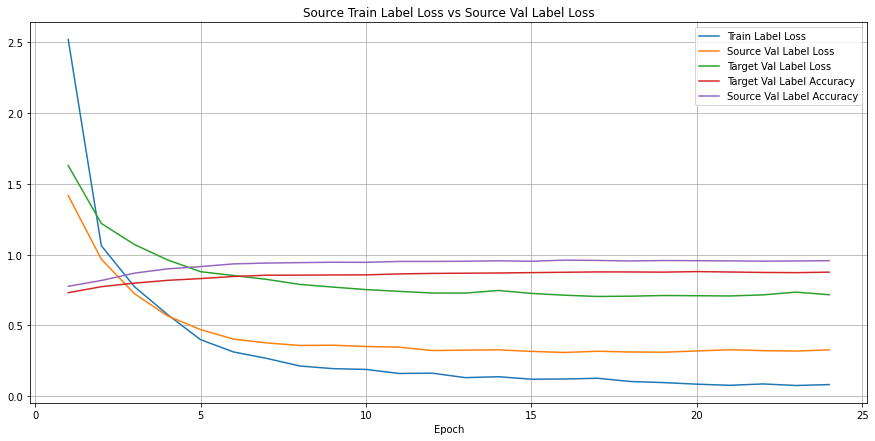

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

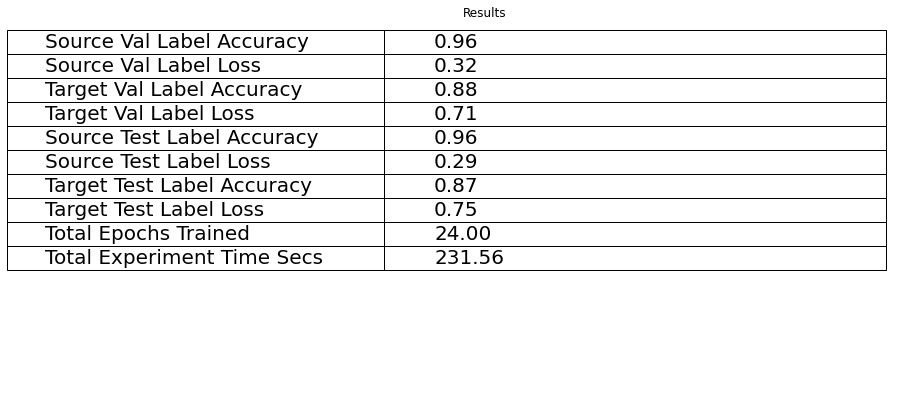

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

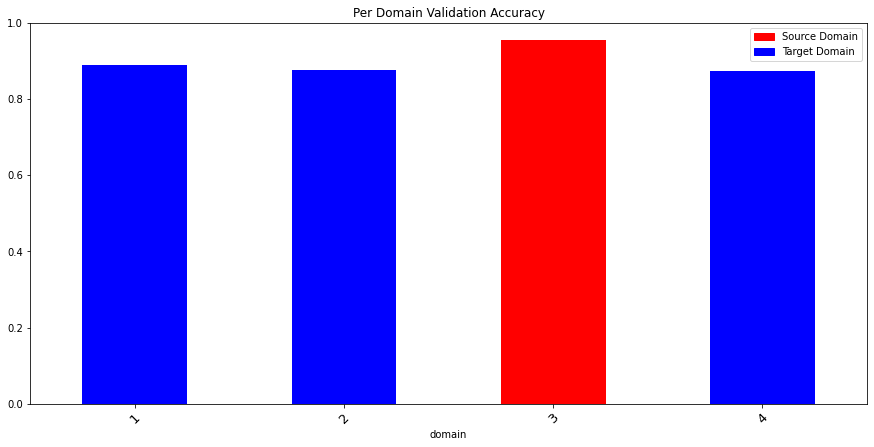

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9564102564102565 Target Test Label Accuracy: 0.8707264957264957
Source Val Label Accuracy: 0.9570512820512821 Target Val Label Accuracy: 0.8801282051282051


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "